In [1]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,plot_roc_curve,confusion_matrix
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from normalize_data import normalize_data
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV,train_test_split
from bayes_opt import BayesianOptimization 

In [3]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [4]:
# df = normalize_data(df)
# df_test = normalize_data(df_test)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11153 entries, 0 to 11152
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   job_level                              11153 non-null  object 
 1   job_duration_in_current_job_level      11153 non-null  float64
 2   person_level                           11153 non-null  object 
 3   job_duration_in_current_person_level   11153 non-null  float64
 4   job_duration_in_current_branch         11153 non-null  float64
 5   Employee_type                          11153 non-null  object 
 6   gender                                 11153 non-null  int64  
 7   age                                    11153 non-null  int64  
 8   marital_status_maried(Y/N)             11153 non-null  object 
 9   number_of_dependences                  11153 non-null  int64  
 10  Education_level                        11153 non-null  object 
 11  GP

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   job_level                              6000 non-null   object 
 1   job_duration_in_current_job_level      6000 non-null   float64
 2   person_level                           6000 non-null   object 
 3   job_duration_in_current_person_level   6000 non-null   float64
 4   job_duration_in_current_branch         6000 non-null   float64
 5   Employee_type                          6000 non-null   object 
 6   gender                                 6000 non-null   int64  
 7   age                                    6000 non-null   int64  
 8   marital_status_maried(Y/N)             6000 non-null   object 
 9   number_of_dependences                  6000 non-null   int64  
 10  Education_level                        6000 non-null   object 
 11  GPA 

# Drop null values and duplicates

In [6]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Convert age

In [7]:
df['age'] = df['age'].apply(lambda x: 2021 - x)
df_test['age'] = df_test['age'].apply(lambda x: 2021 - x)

# Convert year_Graduated

In [8]:
df['year_graduated']=df['year_graduated'].apply(lambda x: 2021-x)
df_test['year_graduated']=df_test['year_graduated'].apply(lambda x: 2021-x)

In [ ]:
# Drop marital status maried
df.drop('marital_status_maried(Y/N)',axis=1,inplace=True)
df_test.drop('marital_status_maried(Y/N)',axis=1,inplace=True)

* Category Feature
- untuk job_level selain JG04 dan JG05 replace rare_var
- untuk person_level selain PG03,PG04, PG05, PG06 replace jadi rare_var
- untuk Education_level selain level1, level_3, dan level_4 convert jad rare_var


# Convert Rare variable to 'Rare_var' in train dataset for categorical features

In [11]:
category_features=[feat for feat in df.columns if df[feat].dtypes =='O']

In [12]:
for feat in category_features:
  temp = df.groupby(feat)['Best Performance'].count()/len(df)
  temp_df = temp[temp>0.01].index
  df[feat] = np.where(df[feat].isin(temp_df),df[feat],'Rare_var')

# Convert Rare Variable to 'Rare_var' in test dataset for categorical features

In [13]:
jl = ['JG04','JG05']
pl = ['PG03','PG04','PG05','PG06']
el = ['level_1','level_3','level_4']
df_test['job_level']= df_test['job_level'].apply(lambda x: x if x in jl else 'Rare_val')
df_test['person_level']=df_test['person_level'].apply(lambda x:x if x in pl else 'Rare_val')
df_test['Education_level']=df_test['Education_level'].apply(lambda x:x if x in el else 'Rare_val')

* Discrete Feature
- untuk number_of_dependences selain 0,1,2,3 convert jadi rare_var
- untuk branch rotation selain range (1-11) convert jadi rare_var
- untuk job rotation selain range (2-9) convert jadi rare_Var
- untuk annual leave selain 0-10 convert jadi rare_var

# Convert  Rare variable to 'Rare_var' in train dataset for discrete features

In [14]:
# numerical_features = [feat for feat in df.columns if df[feat].dtypes !='O' and feat != 'Best Performance']
# discrete_features=[feat for feat in numerical_features if len(df[feat].unique())<27]
# len(discrete_features)

In [15]:
# for feat in discrete_features:
#   temp = df.groupby(feat)['Best Performance'].count()/len(df)
#   temp_df = temp[temp>0.01].index
#   df[feat] = np.where(df[feat].isin(temp_df),df[feat],"Rare_var")

# Convert Rare variable in test dataset for discrete features

In [16]:
# nod = [i for i in range(4)]
# br = [i+1 for i in range(11)]
# jr = [i+2 for i in range(8)]
# al = [i for i in range(11)]
# aoo = [i for i in range(8)]
# df_test['number_of_dependences'] = df_test['number_of_dependences'].apply(lambda x: x if x in nod else 'Rare_var')
# df_test['branch_rotation'] = df_test['branch_rotation'].apply(lambda x: x if x in br else 'Rare_var')
# df_test['job_rotation'] = df_test['job_rotation'].apply(lambda x : x if x in jr else 'Rare_var')
# df_test['annual_leave'] = df_test['annual leave'].apply(lambda x: x if x in al else 'Rare_var')
# df_test['assign_of_otherposition'] = df_test['assign_of_otherposition'].apply(lambda x: x if x in aoo else 'Rare_var')

In [17]:
# col = df.pop("Best Performance")
# df.insert(25,col.name,col)
obj_columns_train = df.select_dtypes(['object']).columns
df[obj_columns_train] = df[obj_columns_train].astype('category')
#merubah category menjadi int column
cat_columns_train = df.select_dtypes(['category']).columns
df[cat_columns_train] = df[cat_columns_train].apply(lambda x:x.cat.codes)
#menaruh kolum Best Performance ke index terakhir 
df[cat_columns_train]

,job_level,person_level,Employee_type,marital_status_maried(Y/N),Education_level
0,0,0,0,1,0
1,0,0,0,1,1
2,1,3,2,1,1
3,1,3,0,1,1
4,1,3,0,1,1
...,...,...,...,...,...
11148,0,0,0,1,0
11149,0,0,1,1,0
11150,0,0,1,1,0
11151,0,0,0,1,0


In [18]:
obj_columns_test = df_test.select_dtypes(['object']).columns
df_test[obj_columns_test] = df_test[obj_columns_test].astype('category')
#merubah category menjadi int column
cat_columns_test = df_test.select_dtypes(['category']).columns
df_test[cat_columns_test] = df_test[cat_columns_test].apply(lambda x:x.cat.codes)
df_test[cat_columns_test]

,job_level,person_level,Employee_type,marital_status_maried(Y/N),Education_level
0,0,0,0,0,2
1,0,0,1,0,3
2,0,0,0,1,3
3,0,0,0,1,3
4,0,0,1,1,3
...,...,...,...,...,...
5995,0,0,1,1,3
5996,0,0,0,1,3
5997,0,0,0,1,3
5998,1,2,0,1,3


In [19]:
train= reduce_mem_usage(df)
test = reduce_mem_usage(df_test)
print("Shape of train set: ",train.shape)
print("Shape of train set: ",test.shape)

Mem. usage decreased to  0.38 Mb (75.8% reduction)
Mem. usage decreased to  0.15 Mb (79.7% reduction)
Shape of train set:  (11152, 22)
Shape of train set:  (6000, 21)


In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = train.values
ix = [i for i in range(data.shape[1]) if i != 21]
X, y = data[:, ix], data[:, 21]
X = scaler.fit_transform(X)

In [21]:
cat_columns_train = cat_columns_train.to_list()
cat_columns_test = cat_columns_test.to_list()

In [22]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, max_depth, max_bin, min_data_in_leaf, subsample, num_round, path_smooth,lambda_l1,lambda_l2,min_gain_to_split,min_child_weight):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['subsample'] = max(min(subsample, 1), 0)
        params['num_round'] = int(round(num_round))
        params['path_smooth']=max(min(path_smooth,1),0)
        params['lambda_l1']=max(min(lambda_l1,1),0)
        params['lambda_l2']=max(min(lambda_l2,1),0)
        params['min_gain_to_split'] = max(min(lambda_l2,1),0)
        params['min_child_weight'] = max(min(min_child_weight,1),0)  
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =1, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 0.05), #AMAN #0.01,0.05
                                            'num_leaves': (5,75), #aman 24,50 24,75 65962 ##5,75
                                            'feature_fraction': (0.2, 0.9),#aman
                                            'max_depth': (2,20),#aman
                                            'max_bin':(24,40), #aman 24 40
                                            'min_data_in_leaf': (20,120),
                                           'subsample': (0.01, 1.0), #aman
                                           'num_round':(1,1500), #aman
                                            'path_smooth':(0.1,80),
                                            'lambda_l1':(0.001,0.1), #aman
                                            'lambda_l2':(0.001,0.1), #aman
                                            'min_gain_to_split':(0.001,0.1), #aman
                                            'min_child_weight': (0.01, 1), #aman
                                            }, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

GBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1150]	cv_agg's auc: 0.576854 + 0.0142549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1151]	cv_agg's auc: 0.576854 + 0.0142549
[LightGBM] [Warning] No fur

In [23]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['boosting']='dart'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params[1]['num_round']=int(round(opt_params[1]['num_round']))
opt_params[1]['extra_trees']=True
opt_params[1]['early_stopping_rounds'] = 50
opt_params=opt_params[1]
opt_params

{'feature_fraction': 0.8649759990793511,
 'lambda_l1': 0.01430184960557293,
 'lambda_l2': 0.04016932099058485,
 'learning_rate': 0.04351944404135696,
 'max_bin': 35,
 'max_depth': 18,
 'min_child_weight': 0.5919511860804348,
 'min_data_in_leaf': 113,
 'min_gain_to_split': 0.09441744823990518,
 'num_leaves': 26,
 'num_round': 1183,
 'path_smooth': 69.65461692197046,
 'subsample': 0.669556880597742,
 'objective': 'binary',
 'metric': 'auc',
 'boosting': 'dart',
 'is_unbalance': True,
 'boost_from_average': False,
 'extra_trees': True,
 'early_stopping_rounds': 50}

In [24]:
%%time 
target=train['Best Performance']
features= [c for c in train.columns if c not in ['Best Performance']]


folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=31416)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=cat_columns_train)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=cat_columns_train)
    
    # the best score itertation di 1500
    # num_round = 1500
    clf = lgb.train(opt_params, trn_data, valid_sets = [trn_data, val_data], verbose_eval=5)
    # clf = lgb.LGBMClassifier(opt_params, trn_data, valid_sets = [trn_data, val_data], verbose_eval=5, early_stopping_rounds = 50)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


-inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[955]	training's auc: 0.697415	valid_1's auc: 0.548761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[960]	training's auc: 0.697683	valid_1's auc: 0.549172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [25]:
pd.DataFrame(predictions,columns=['Best Performance']).to_csv('hyper_adjust_opt_lgbm.csv')

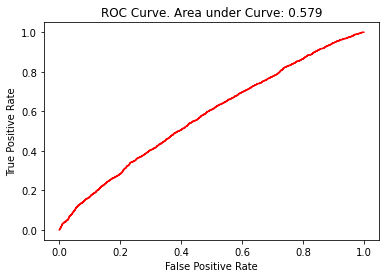

In [26]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, threshold = roc_curve(target, oof)
roc_auc = auc(fpr, tpr)

plt.title("ROC Curve. Area under Curve: {:.3f}".format(roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
_ = plt.plot(fpr, tpr, 'r')

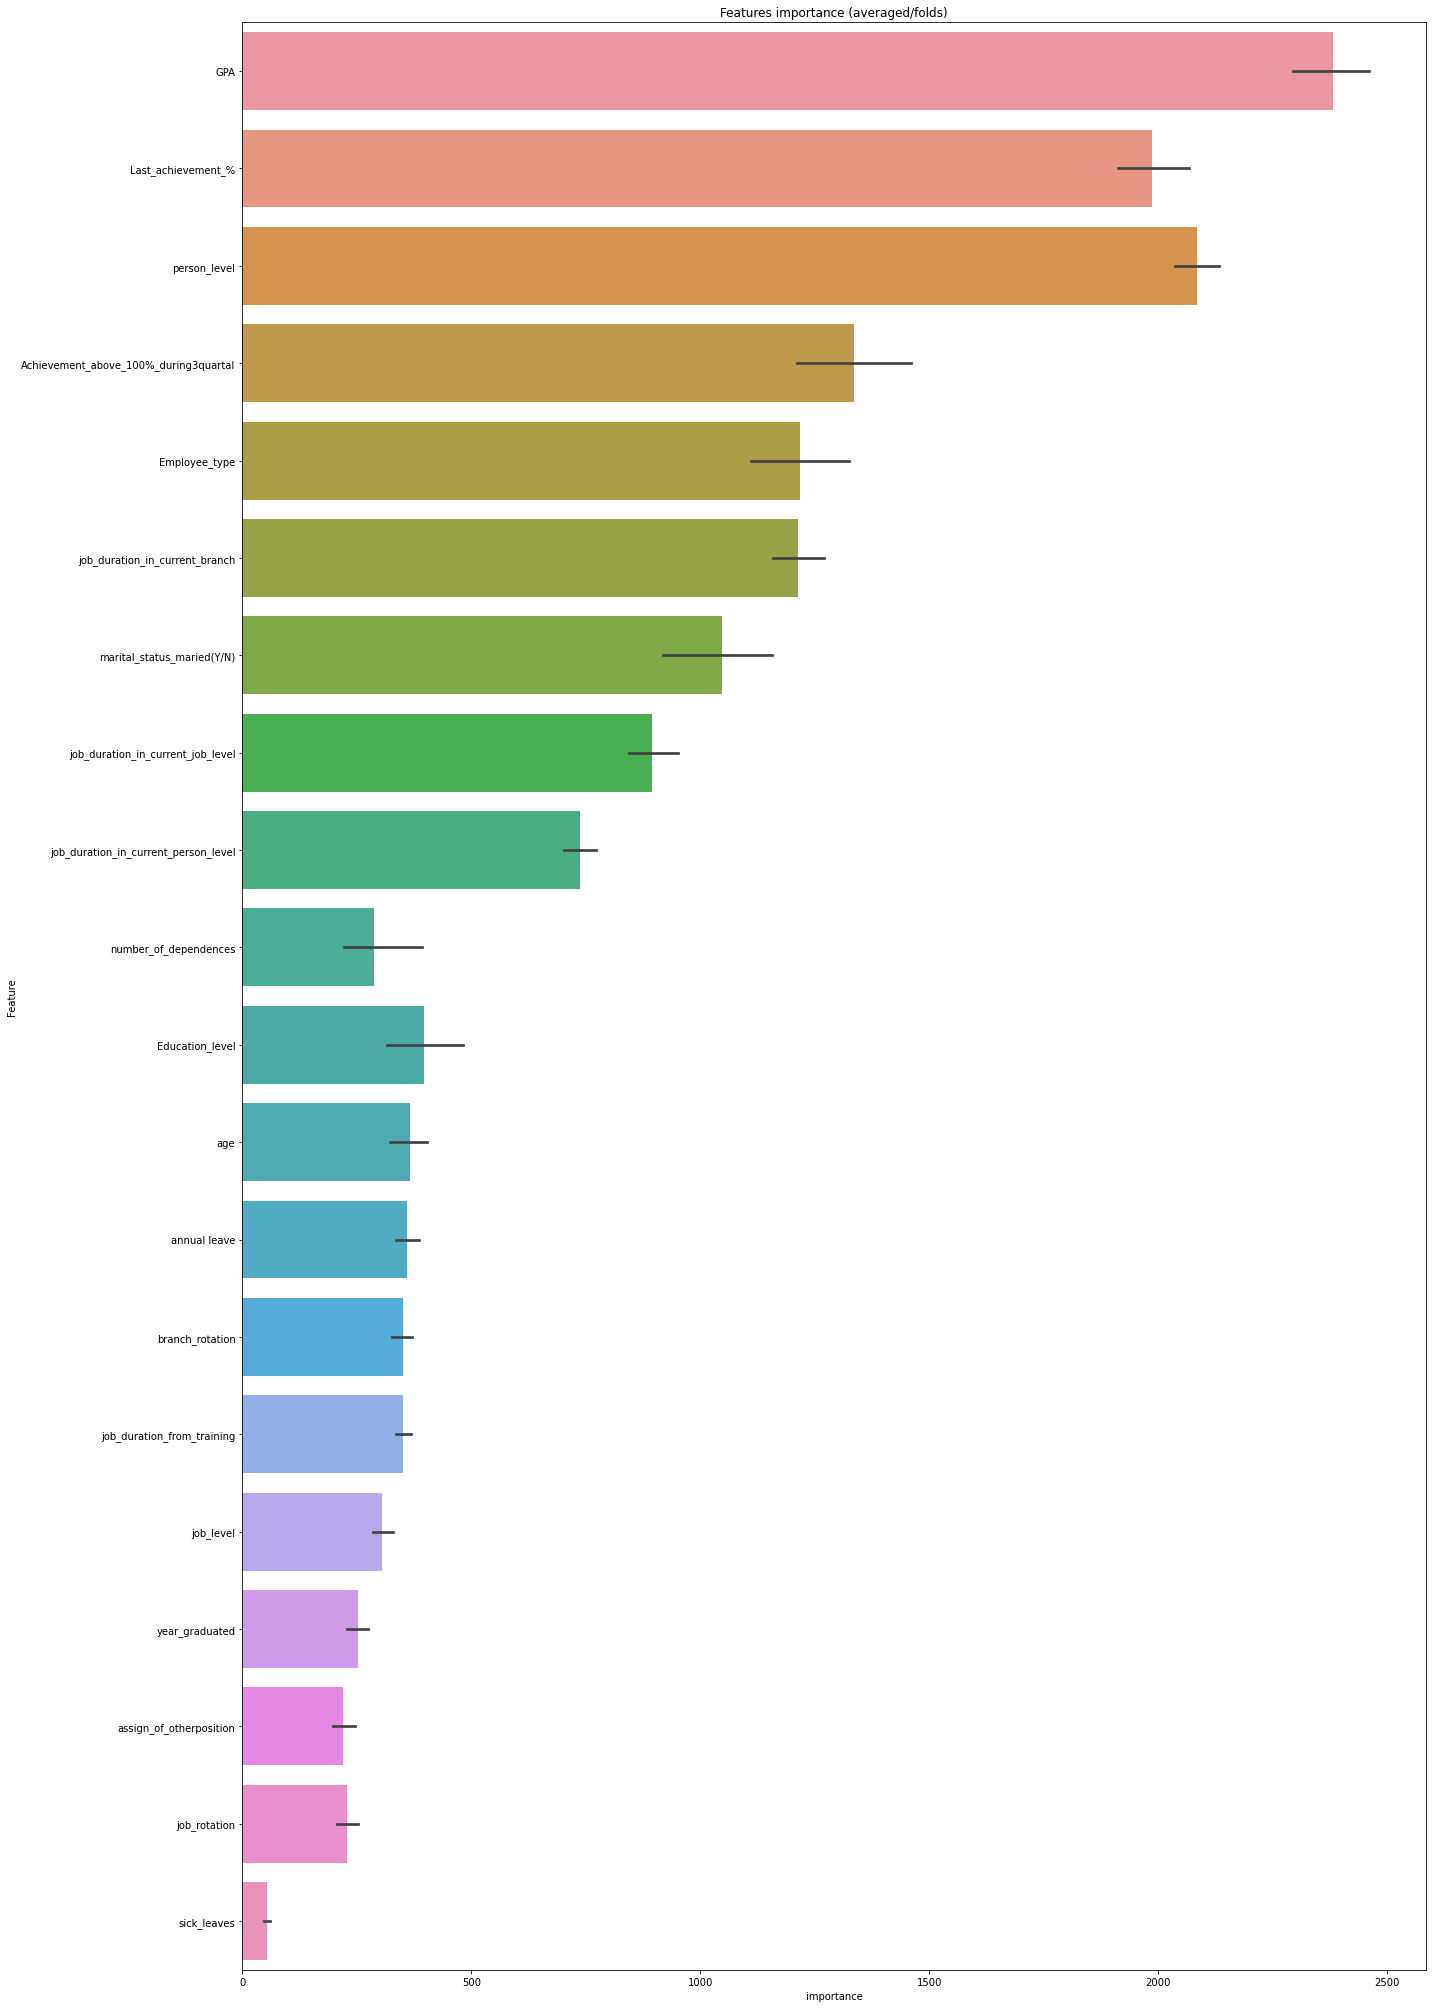

In [27]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(20,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [23]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

NameError: name 'shap' is not defined

In [25]:
#tree visualization
graph = lgb.create_tree_digraph(clf, tree_index=3, name='Tree3' )
graph.graph_attr.update(size="110,110")
graph

ImportError: You must install graphviz to plot tree.